In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import spacy
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical
EN = spacy.load('en_core_web_sm')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Preprocessed_data = pd.read_pickle('/content/drive/MyDrive/Data/NLP/Preprocessed_data.pkl')
# Preprocessed_data.shape

(985352, 11)

In [ ]:
# Preprocessed_data.head()

,original_title,post_corpus,question_content,question_url,tags,answer_content,processed_title,sentiment_polarity,sentiment_subjectivity,overall_scores,overall_scores_norm
0,Print to hardcopy using javascript - landscape...,print hardcopy using javascript landscape mode...,print hardcopy using javascript landscape mode...,https://stackoverflow.com/questions/7722453,javascript|html|css,mark size margins printed page css rule css ja...,print hardcopy using javascript landscape mode,0.258333,0.825000,10,0.000329
1,Change LC_CTYPE for PostgreSQL and PostGIS use,change lc_ctype postgresql postgis use im walk...,change lc_ctype postgresql postgis use im walk...,https://stackoverflow.com/questions/8351436,postgresql|locale|postgis|geodjango,better specify locale database encoding figure...,change lc_ctype postgresql postgis use,0.500000,0.500000,13,0.000455
2,boost asio deadline_timer,boost asio deadline_timer expected code print ...,boost asio deadline_timer expected code print ...,https://stackoverflow.com/questions/3539583,c++|boost|boost-asio,youre creating local variable immediately exit...,boost asio deadline_timer,-0.023810,0.071429,27,0.001041
3,Primitive or wrapper for hibernate primary keys,primitive wrapper hibernate primary keys ive l...,primitive wrapper hibernate primary keys ive l...,https://stackoverflow.com/questions/3535791,java|hibernate|orm,prefer using wrapper types otherwise use primi...,primitive wrapper hibernate primary keys,0.084722,0.606944,11,0.000371
4,Primitive or wrapper for hibernate primary keys,primitive wrapper hibernate primary keys ive l...,primitive wrapper hibernate primary keys ive l...,https://stackoverflow.com/questions/3535791,java|hibernate|orm,hibernate point view doesnt change anything hi...,primitive wrapper hibernate primary keys,0.024318,0.428561,35,0.001376


In [ ]:
# # saving 50000 rows of Preprocessed data to be used later as original dataset crash RAM due to its huge size of 985352 rows
# Preprocessed_data.iloc[:50000,:].to_pickle('/content/drive/MyDrive/Data/NLP/Preprocessed_data_50000.pkl')

In [2]:
# read small dataset, execute below cells, train model
Preprocessed_data = pd.read_pickle('/content/drive/MyDrive/Data/NLP/Preprocessed_data_50000.pkl')

In [ ]:
# Make a dict having tag frequencies
Preprocessed_data.tags = Preprocessed_data.tags.apply(lambda x: x.split('|'))# Making the list of tags
tag_freq_dict = {}
for tags in Preprocessed_data.tags:
    for tag in tags:
        if tag not in tag_freq_dict:
            tag_freq_dict[tag] = 0
        else:
            tag_freq_dict[tag] += 1

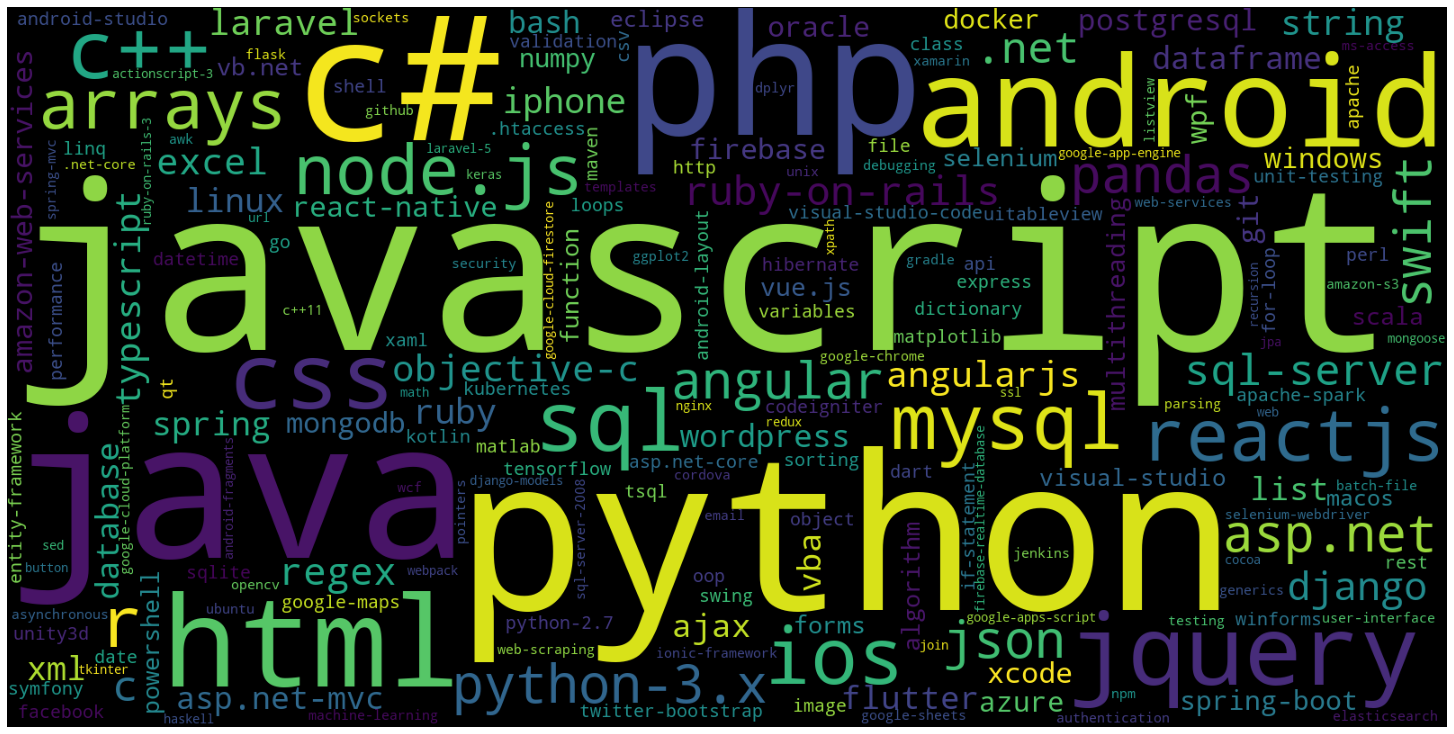

In [ ]:
# Visualize all tags based on their frequencies using a WordCloud
wordcloud = WordCloud(background_color='black',
                      width=1600,
                      height=800,
                    ).generate_from_frequencies(tag_freq_dict)

fig = plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('/content/drive/MyDrive/Data/NLP/stackoverflow_tags_cloud.png')
plt.show()

There exists a lot of "stray" tags which may appear only once or twice as compared to thousands of occurences for other tags. This increases the dimensions of the ground truth data, which is not desirable for our model. Extract the top 500 tags based on their occurences.

In [ ]:
# Get most common tags
tags_to_use = 500
tag_freq_dict_sorted = dict(sorted(tag_freq_dict.items(), key=lambda x: x[1], reverse=True))
final_tags = list(tag_freq_dict_sorted.keys())[:tags_to_use]

In [ ]:
# Change tag data to only for final_tags
final_tag_data = []
for tags in Preprocessed_data.tags:
    temp = []
    for tag in tags:
        if tag in final_tags:
            temp.append(tag)
    final_tag_data.append(temp)

In [ ]:
len(final_tag_data)

985352

In [ ]:
# # save final tag data
# with open('/content/drive/MyDrive/Data/NLP/final_tag_data.pickle', 'wb') as handle:
#     pickle.dump(final_tag_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# load final tag data
with open('/content/drive/MyDrive/Data/NLP/final_tag_data.pickle', 'rb') as handle:
    final_tag_data = pickle.load(handle)

Since we are dealing with multi label data, i.e. there are more than one answers for each input, so, use the MultiLabelBinarizer from sklearn

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(final_tag_data)
tags_encoded.shape

(985352, 500)

In order for our model to understand the raw text data, we need to vectorize it. Bag of Words and TF-IDF are very common approaches for vectorizing. However, since I would be using an artificial neural network as my model, the sparse nature of BOW and TFIDF would pose a problem. Thus I decided to go for Word Embeddings, which are dense vector representations and thus perfect for our neural network.

The way talk on StackOverflow is very technical and they use a very specific vocabulary of words, it is not a good idea to use pre-trained WordEmbedding (although google has a lot of good ones) because they are trained on plain English text such a Shakespeare and would not be able to understand the relations between the words in our vocabulary. Thus I decided to train a WordEmbeddings model of my own from scratch.

In [6]:
Preprocessed_data_mini = pd.read_pickle('/content/drive/MyDrive/Data/NLP/Preprocessed_data_mini.pkl')

In [7]:
len(np.array(Preprocessed_data_mini.post_corpus))

408611

In [7]:
# Word2Vec
import gensim

# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 5
W2V_EPOCH = 16
W2V_MIN_COUNT = 10

# Collect corpus for training word embeddings
documents = [_text.split() for _text in np.array(Preprocessed_data_mini.post_corpus)[0:50000]]  # I used the entire corpus for training, because it contains the entire conversation of related to a user's posts

# Challenge: documents is not being created for Preprocessed_data having around 10 lakh rows, create for that.

In [9]:
# Train Word Embeddings and save

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save('/content/drive/MyDrive/Models/NLP/Stackoverflow_word2vec_embeddings_lite.bin')
print("END embedding created!!")


Vocab size 27847
END embedding created!!


Gensim Word2Vec is a widely used word representation technique that uses neural networks under the hood. The resulting word representation or embeddings can be used to infer semantic similarity between words and phrases, expand queries, surface related concepts and more.

In [10]:
# Load pre-trained model
w2v_model = gensim.models.word2vec.Word2Vec.load('/content/drive/MyDrive/Models/NLP/Stackoverflow_word2vec_embeddings_lite.bin')

In [11]:
# Testing Word Embeddings
print('Terms most similar to "python"')
print(w2v_model.wv.most_similar("python"))
print('-'*100,'\n')

print('Terms most similar to "Node"')
print(w2v_model.wv.most_similar("node"))
print('-'*100,'\n')

print('Terms most similar to "java"')
print(w2v_model.wv.most_similar("java"))
print('-'*100,'\n')

print('Terms most similar to "server"')
print(w2v_model.wv.most_similar("server"),'\n')

Terms most similar to "python"
[('pandas', 0.6177120208740234), ('pythons', 0.5857284665107727), ('interpreter', 0.5646480321884155), ('numpy', 0.5605911612510681), ('tensorflow', 0.540498673915863), ('powershell', 0.5392714738845825), ('bash', 0.5375169515609741), ('java', 0.5356320738792419), ('shell', 0.5317057371139526), ('ruby', 0.5270105004310608)]
---------------------------------------------------------------------------------------------------- 

Terms most similar to "Node"
[('nodes', 0.6623690128326416), ('nodejs', 0.5747358798980713), ('express', 0.49805957078933716), ('subnodes', 0.4948147237300873), ('tree', 0.49370986223220825), ('nodename', 0.46908363699913025), ('hierarchyid', 0.46852177381515503), ('leaf', 0.46323058009147644), ('unhandledpromiserejectionwarning', 0.46158286929130554), ('traverse', 0.45058804750442505)]
---------------------------------------------------------------------------------------------------- 

Terms most similar to "java"
[('scala', 0.61374

In [5]:
Preprocessed_data.processed_title.shape, tags_encoded.shape

((985352,), (985352, 500))

In [8]:
np.array(Preprocessed_data.processed_title)

array(['print hardcopy using javascript landscape mode',
       'change lc_ctype postgresql postgis use',
       'boost asio deadline_timer', ...,
       'finding number days two days week',
       'assigning array member struct',
       'get gcp cloud function logs labelexecutionid'], dtype=object)

In [11]:
tags_encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Model training

- ## Splitting data into training and test set


In [22]:
# Split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(Preprocessed_data.processed_title)[:50000], tags_encoded[:50000], test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 40000
TEST size: 10000


In [13]:
y_train.shape

(40000, 500)

## Tokenizing the input data
The input data is tokenized using keras's Tokenizer. 

**Note: It was trained on the entire corpus instead of only the titles**. The reason for that is because I wanted to incorporate as many different words necessary into the vocabulary, because the titles provide very less information. 

In [13]:
# Tokenizing
#  Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Preprocessed_data.post_corpus[:50000])
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# # saving
# import pickle
# with open('/content/drive/MyDrive/Models/NLP/tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Found 516953 unique tokens.


In [4]:
# loading tokenizer
import pickle
with open('/content/drive/MyDrive/Models/NLP/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

Found 516953 unique tokens.


In order to have a constant size for the input, a pre-defined size called 'MAX_SEQUENCE_LENGTH' is used. 

Any input sequence more than this size is truncated, and padded by adding a special PAD token for sequences smaller than it. 

In [23]:
# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Shape of data tensor: (40000, 100)


In [11]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(516954, 100)


In [24]:
# rough
len(tokenizer.word_index)

516953

In [15]:
import keras.backend as K

# Custom loss function to handle multilabel classification task
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    y_true = K.cast(y_true, dtype='float32')
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

## Build Model

In [24]:
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units = 10000,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )  
model.add(Dropout(0.35))
model.add(Dense(units = 1150,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dropout(0.25))
model.add(Dense(units = 750,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dense(500, activation='sigmoid'))

model.summary()

model.compile(loss=multitask_loss,
              optimizer="adam")
              
# Train Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 1024
history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=15,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

# Save model
model.save('/content/drive/MyDrive/Models/NLP/Tag_predictor_mini.h5')
model.save_weights("/content/drive/MyDrive/Models/NLP/Tag_predictor_mini_weights.h5")
model_json = model.to_json()
with open("/content/drive/MyDrive/Models/NLP/model.json", "w") as json_file:
    json_file.write(model_json)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          51695400  
                                                                 
 lstm_2 (LSTM)               (None, 500)               1202000   
                                                                 
 dense_8 (Dense)             (None, 10000)             5010000   
                                                                 
 dropout_4 (Dropout)         (None, 10000)             0         
                                                                 
 dense_9 (Dense)             (None, 1150)              11501150  
                                                                 
 dropout_5 (Dropout)         (None, 1150)              0         
                                                                 
 dense_10 (Dense)            (None, 750)              

In [25]:
# Helper function to save the training history for plotting purposes

import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

In [26]:
from keras.models import load_model
import keras.losses

keras.losses.multitask_loss = multitask_loss
model = load_model('/content/drive/MyDrive/Models/NLP/Tag_predictor_mini.h5')

20/20 [==============================] - 67s 3s/step - loss: 6.9205
LOSS: 6.920530319213867


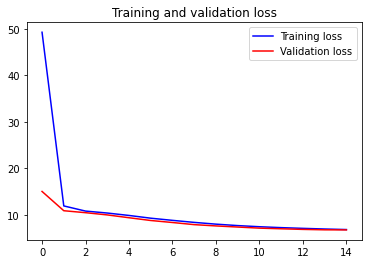

In [27]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("LOSS:",score)

# loss = history['loss']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [28]:
# A wrapper function in order to predict the tags for any given input

def predict_tags(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    prediction = model.predict([x_test])[0]
    for i,value in enumerate(prediction):
        if value > 0.5:
            prediction[i] = 1
        else:
            prediction[i] = 0
    tags = tag_encoder.inverse_transform(np.array([prediction]))
    return tags

In [29]:
test_idx = np.random.randint(len(X_test), size=5)

for idx in test_idx:
    test_case = idx
    print('Test Case: ' + str(X_test[test_case]))
    print('-'*100)
    print('Predicted: ' + str(predict_tags(X_test[test_case])))
    print('Ground Truth: ' + str(tag_encoder.inverse_transform(np.array([y_test[test_case]]))))
    print('\n')

Test Case: change width horizontal scroll bar
----------------------------------------------------------------------------------------------------
Predicted: [('css', 'html')]
Ground Truth: [('css', 'html')]


Test Case: event grid system topic service bus geodisaster recovery
----------------------------------------------------------------------------------------------------
Predicted: [()]
Ground Truth: [()]


Test Case: programming language linkedin app development
----------------------------------------------------------------------------------------------------
Predicted: [()]
Ground Truth: [('php',)]


Test Case: ibm mq cloud connection
----------------------------------------------------------------------------------------------------
Predicted: [()]
Ground Truth: [('java',)]


Test Case: wordpress admin detecting howwhere menu renderedgenerated
----------------------------------------------------------------------------------------------------
Predicted: [('wordpress',)]
Groun

---